In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold, train_test_split
import numpy as np
from tqdm import tqdm  

# Image preprocessing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Dataset path
data_dir = 'dataset'
batch_size = 32
num_epochs = 5
k_folds = 3
num_classes = 3

# Loading the dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
dataset_size = len(dataset)
indices = list(range(dataset_size))

# Divide the training set and test set
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42, stratify=dataset.targets)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training the model
def train_model(model, criterion, optimizer, dataloader, dataset_size):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    
    return epoch_loss, epoch_acc

def validate_model(model, criterion, dataloader, dataset_size):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    
    return epoch_loss, epoch_acc

# Cross Validation
train_indices = np.array(train_indices)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    train_sampler = SubsetRandomSampler(train_indices[train_idx])
    val_sampler = SubsetRandomSampler(train_indices[val_idx])
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    model = models.efficientnet_v2_m(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, len(train_idx))
        val_loss, val_acc = validate_model(model, criterion, val_loader, len(val_idx))
        
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
    
    print(f'Best Val Acc: {best_acc:.4f}')
    
    # Save the best model
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'efficientnet_model_fold_{fold + 1}.pth')


Fold 1/3


C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
----------


Train Loss: 0.9973 Acc: 0.5229
Val Loss: 0.7980 Acc: 0.8375
Epoch 2/5
----------


Train Loss: 0.6259 Acc: 0.7750
Val Loss: 0.4742 Acc: 0.9500
Epoch 3/5
----------


Train Loss: 0.3716 Acc: 0.9417
Val Loss: 0.2866 Acc: 0.9708
Epoch 4/5
----------


Train Loss: 0.2224 Acc: 0.9688
Val Loss: 0.1675 Acc: 0.9792
Epoch 5/5
----------


Train Loss: 0.1186 Acc: 0.9812
Val Loss: 0.1104 Acc: 0.9833
Best Val Acc: 0.9833
Fold 2/3
Epoch 1/5
----------


Train Loss: 0.9807 Acc: 0.5646
Val Loss: 0.7925 Acc: 0.8542
Epoch 2/5
----------


Train Loss: 0.5921 Acc: 0.8646
Val Loss: 0.4400 Acc: 0.9500
Epoch 3/5
----------


Train Loss: 0.3519 Acc: 0.9313
Val Loss: 0.2618 Acc: 0.9583
Epoch 4/5
----------


Train Loss: 0.1795 Acc: 0.9708
Val Loss: 0.1622 Acc: 0.9625
Epoch 5/5
----------


Train Loss: 0.1058 Acc: 0.9875
Val Loss: 0.1005 Acc: 0.9792
Best Val Acc: 0.9792
Fold 3/3
Epoch 1/5
----------


Train Loss: 0.9527 Acc: 0.5750
Val Loss: 0.7525 Acc: 0.8875
Epoch 2/5
----------


Train Loss: 0.5804 Acc: 0.8667
Val Loss: 0.4430 Acc: 0.9292
Epoch 3/5
----------


Train Loss: 0.3472 Acc: 0.9375
Val Loss: 0.2610 Acc: 0.9542
Epoch 4/5
----------


Train Loss: 0.1906 Acc: 0.9604
Val Loss: 0.1450 Acc: 0.9833
Epoch 5/5
----------


Train Loss: 0.1138 Acc: 0.9812
Val Loss: 0.0859 Acc: 0.9958
Best Val Acc: 0.9958


In [4]:

# 最终在测试集上评估
model.load_state_dict(torch.load('efficientnet_model_fold_3.pth'))
test_loss, test_acc = validate_model(model, criterion, test_loader, len(test_indices))
print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

C:\Users\wjc20\AppData\Local\Temp\ipykernel_25632\3767943186.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_model_fold_3.

Test Loss: 0.0955 Acc: 1.0000


In [25]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Custom conversion class to ensure the image is in RGB format
class ConvertToRGB:
    def __call__(self, img):
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        return img

data_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Loading the model
model_path = 'efficientnet_model_fold_3.pth'  
num_classes = 3
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


image_path = 'test.png' 
image = Image.open(image_path)
image = data_transforms(image)
image = image.unsqueeze(0)  


image = image.to(device)

# Classification
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    predicted_class = preds.item()
    predicted_prob = probabilities[0][preds].item()

# Mapping category indexes to category names
class_names = ['flower', 'pod', 'seed'] 
predicted_label = class_names[predicted_class]

print(f'The image is classified as: {predicted_label} with a probability of {predicted_prob:.4f}')



C:\Users\wjc20\AppData\Local\Temp\ipykernel_22680\3164979250.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


The image is classified as: flower with a probability of 0.9886


C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\wjc20\AppData\Local\Temp\ipykernel_14956\2250640626.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_o

Accuracy: 0.8447
F1 Score: 0.8416
Recall: 0.8447
Precision: 0.8584


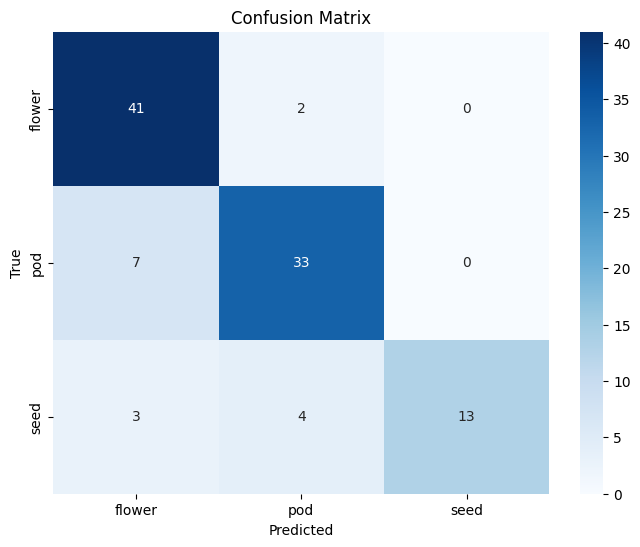

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_data_dir = 'downloads'
batch_size = 32
num_classes = 3

# Loading the test dataset
test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loading the model
model_path = 'efficientnet_model_fold_3.pth'  
model = models.efficientnet_v2_m(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Classify and calculate indicators
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

# Visualising the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
